## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## Dataset

In [2]:
df = pd.read_csv("Churn_Modelling.csv", index_col="RowNumber")

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
X = df.iloc[:, 2:-1]
y = df.iloc[:, -1]

In [6]:
X["HasCrCard"] = X["HasCrCard"].apply(lambda x: "Yes" if x==1 else "No")
X["IsActiveMember"] = X["IsActiveMember"].apply(lambda x: "Yes" if x==1 else "No")

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Studying dataset

In [8]:
numerical_features = [column for column in X.columns if X[column].dtype!="object"]
categorical_features = [column for column in X.columns if column not in numerical_features]

+ Statistics

In [9]:
X_train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,650.550000,38.854625,4.980750,76076.504201,1.532375,100172.282724
std,97.009419,10.449516,2.890142,62581.364700,0.577705,57538.426073
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,583.000000,32.000000,2.000000,0.000000,1.000000,51270.697500
50%,652.000000,37.000000,5.000000,96870.170000,1.000000,100319.840000
75%,718.000000,44.000000,7.000000,127540.865000,2.000000,149618.390000
max,850.000000,88.000000,10.000000,238387.560000,4.000000,199992.480000


In [10]:
X_train.describe(include="object")

,Geography,Gender,HasCrCard,IsActiveMember
count,8000,8000,8000,8000
unique,3,2,2,2
top,France,Male,Yes,Yes
freq,4058,4350,5662,4127


In [11]:
for column in categorical_features:
    print(f">>> {column}: {X_train[column].unique()}")

>>> Geography: ['Spain' 'Germany' 'France']
>>> Gender: ['Female' 'Male']
>>> HasCrCard: ['Yes' 'No']
>>> IsActiveMember: ['No' 'Yes']


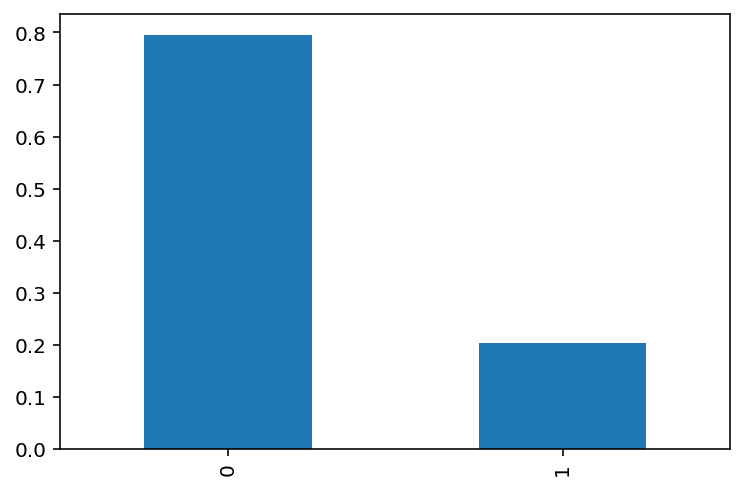

In [12]:
(y_train.value_counts()/len(y_train)).plot(kind="bar");

+ Boxplot

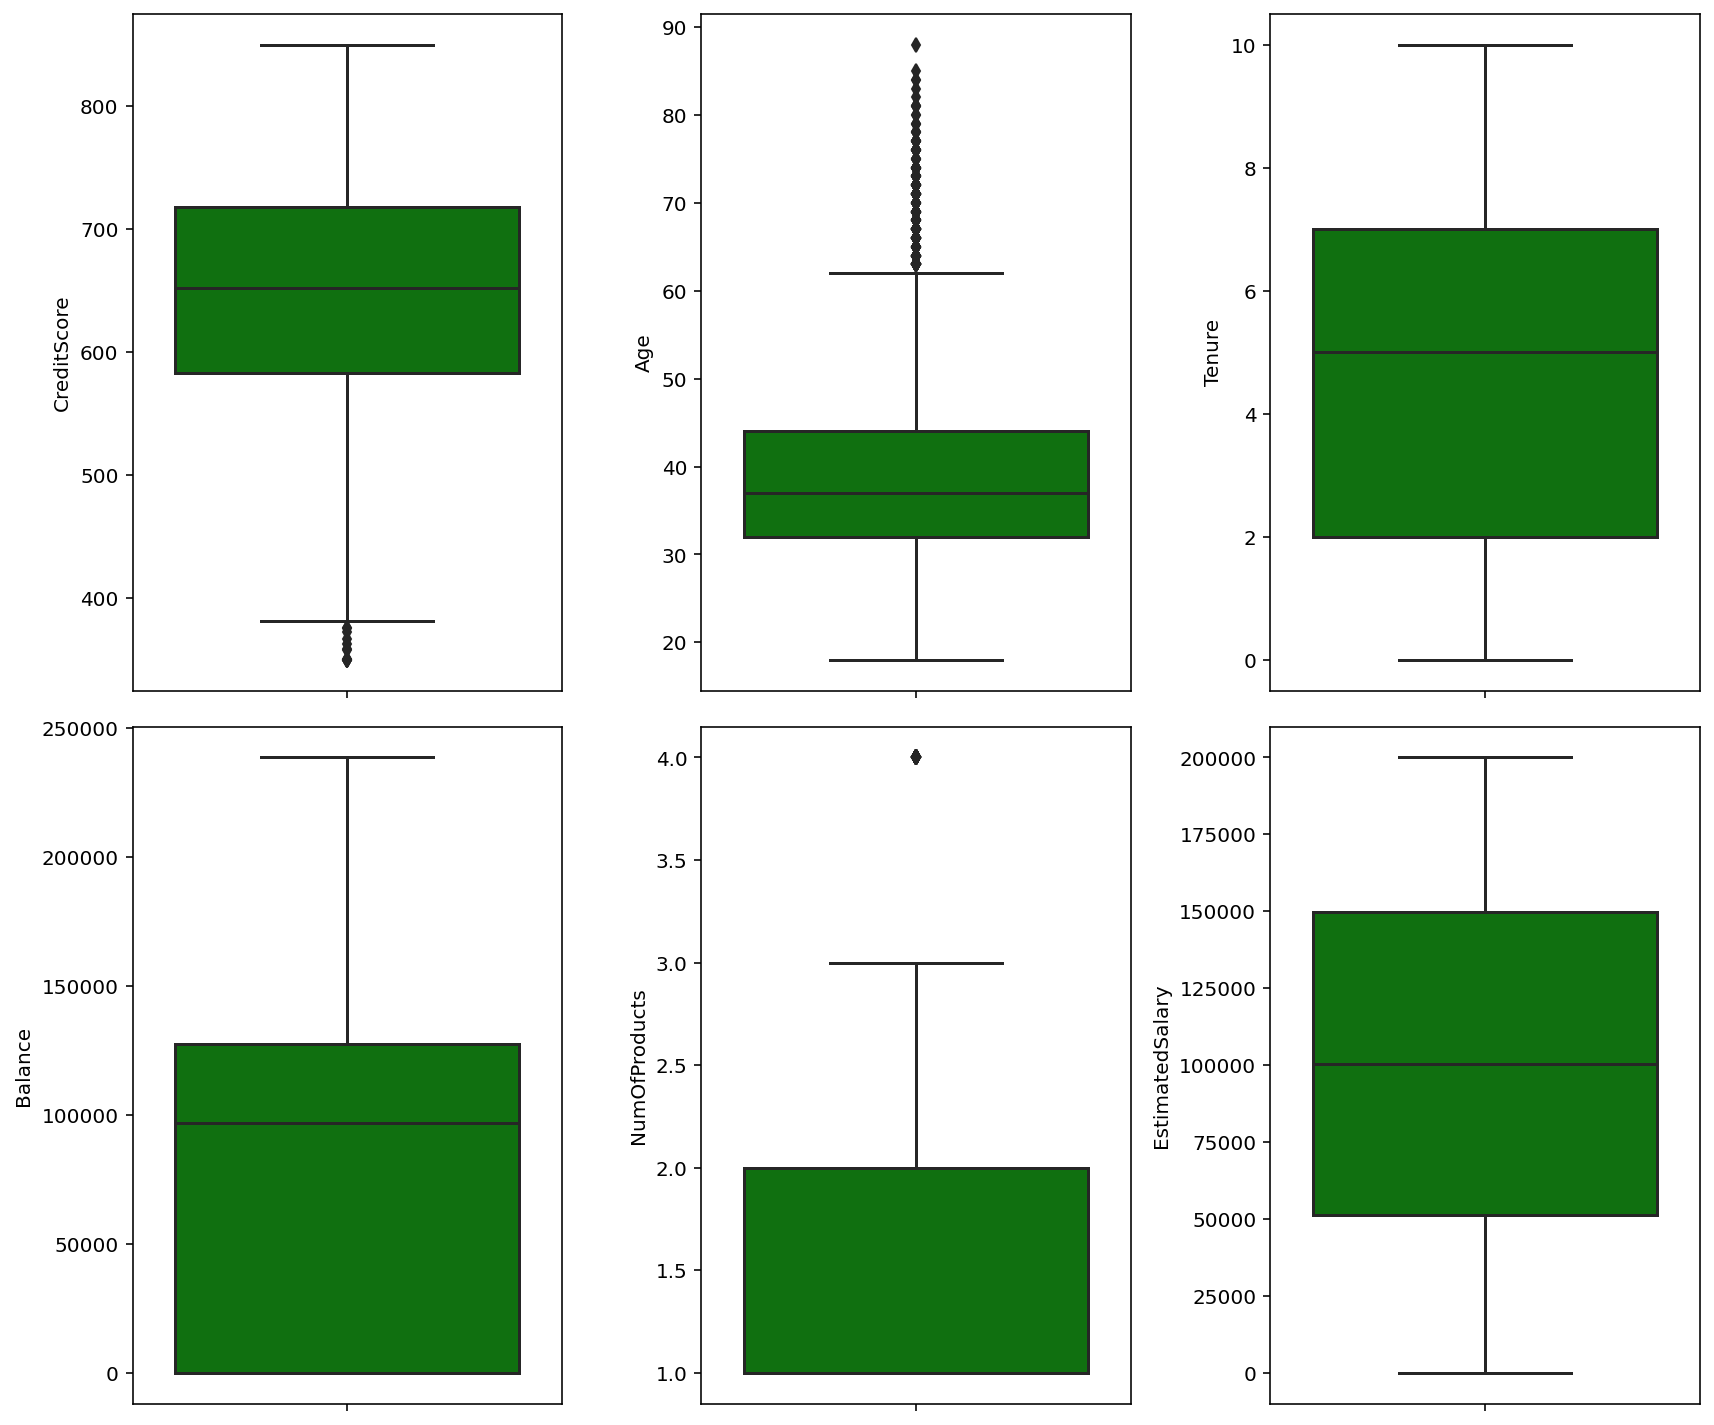

In [13]:
fig, ax = plt.subplots(len(numerical_features)//3+len(numerical_features)%3, 3, figsize=(12,10))

for i, feature in enumerate(numerical_features):
    sns.boxplot(y=feature, data=X_train, color="green", ax=ax[i//3][i%3])
plt.tight_layout()
plt.show()

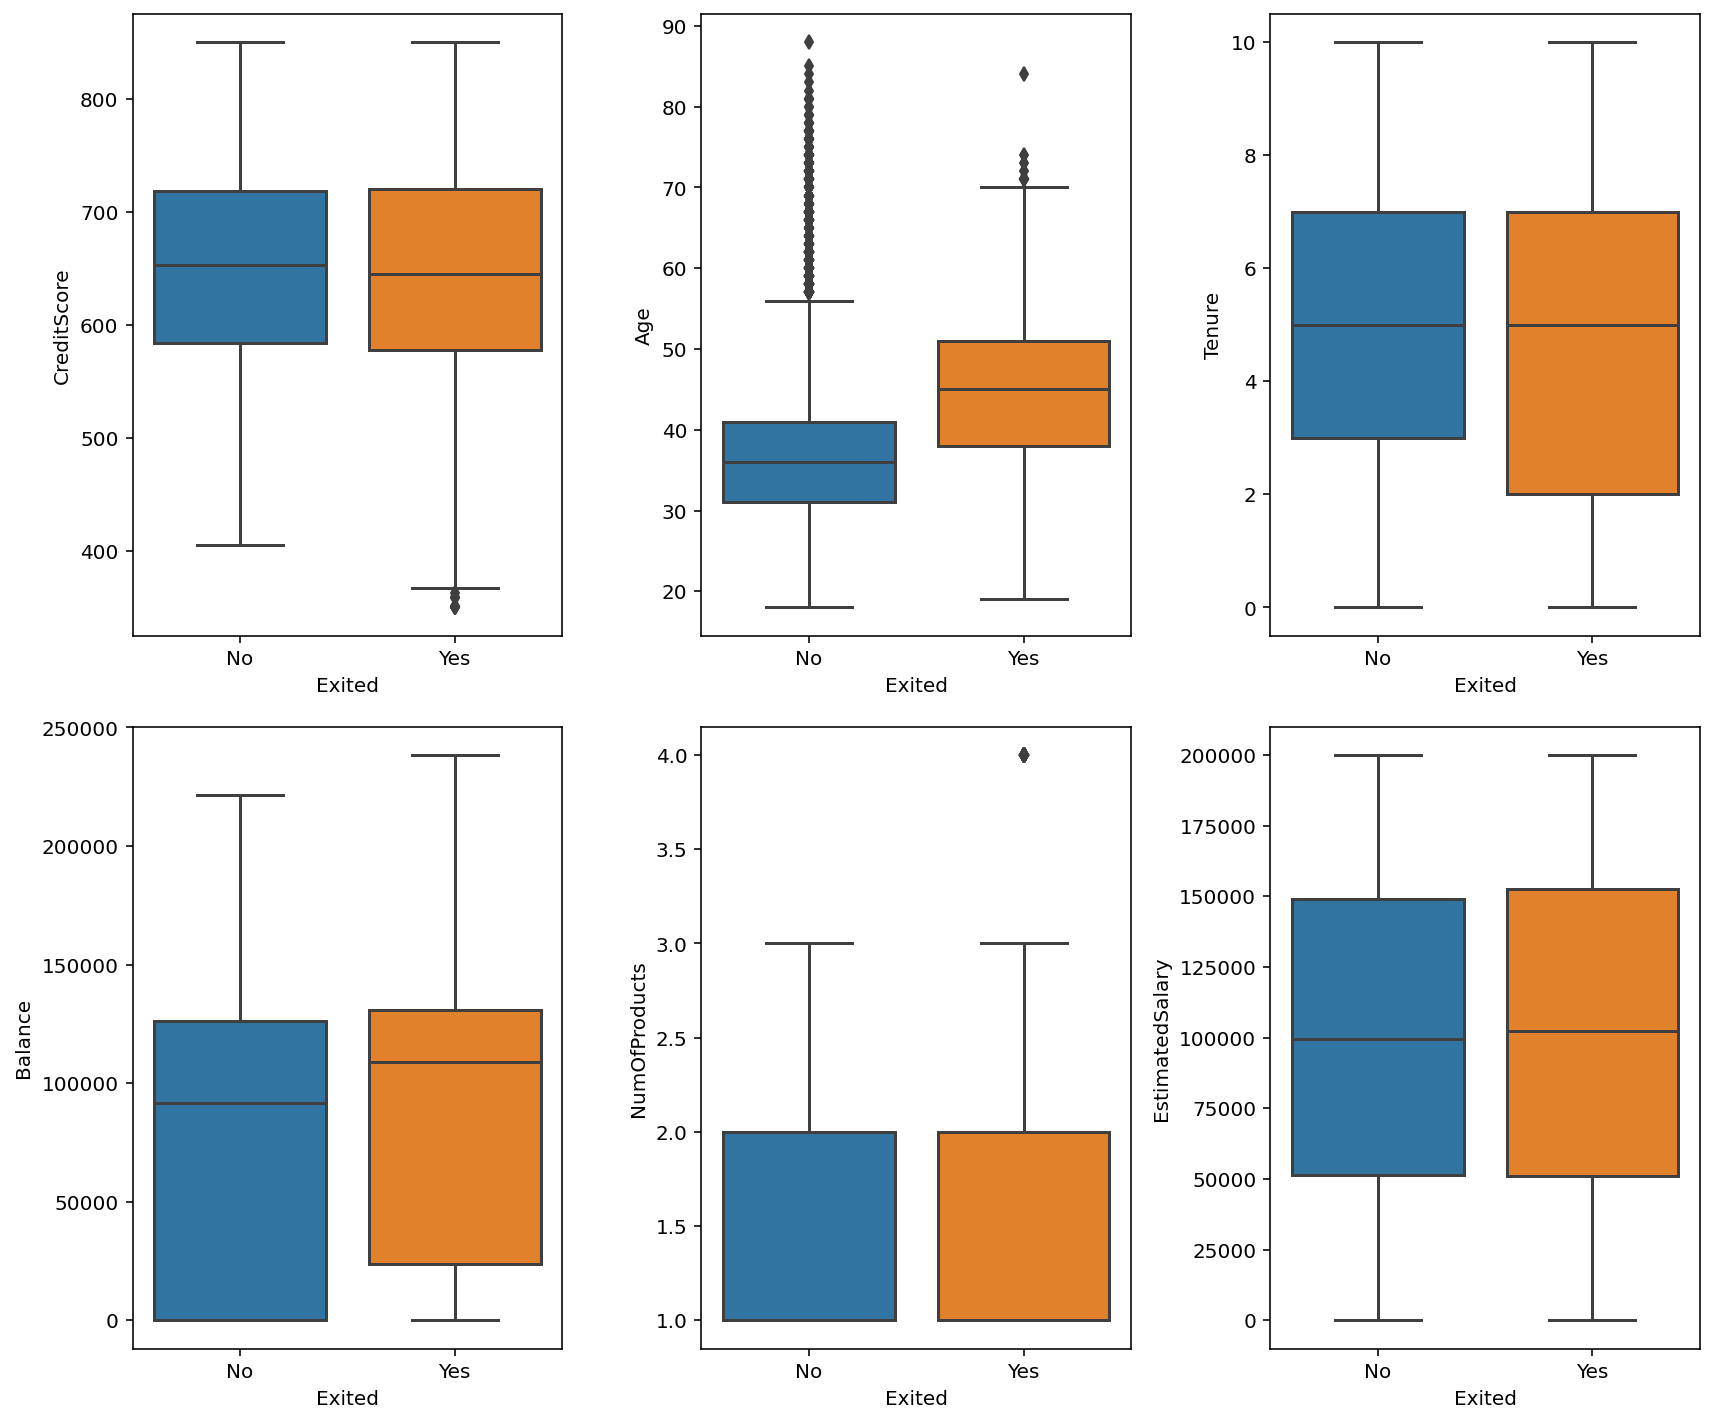

In [14]:
fig, ax = plt.subplots(len(numerical_features)//3+len(numerical_features)%3, 3, figsize=(12,10))
train = pd.concat([X_train, y_train], axis=1)
train["Exited"] = train["Exited"].apply(lambda x: "Yes" if x==1 else "No")

for i, feature in enumerate(numerical_features):
    sns.boxplot(y=feature, x="Exited", data=train, ax=ax[i//3][i%3])
plt.tight_layout()
plt.show()

+ Barplot

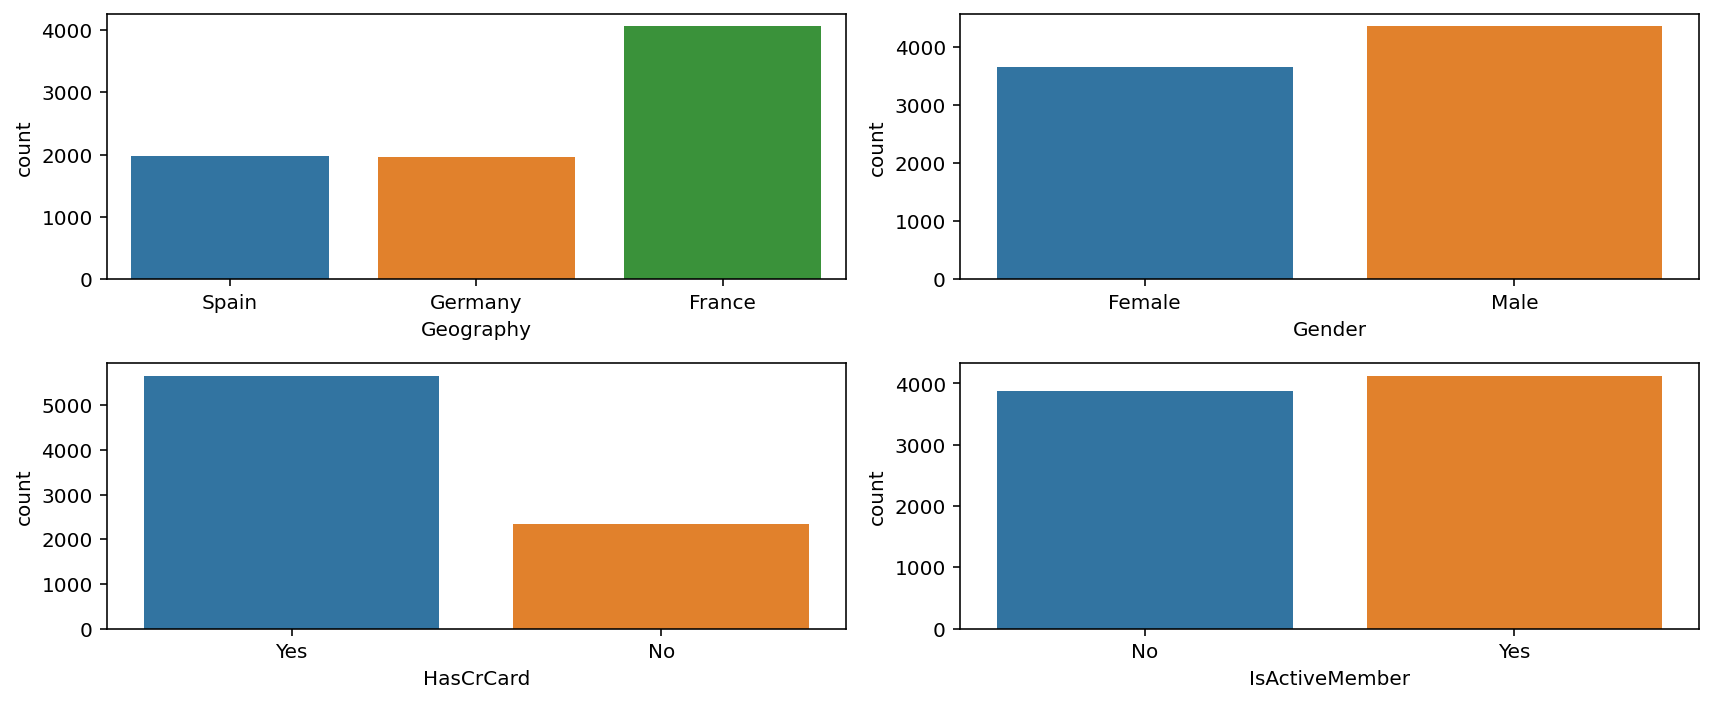

In [15]:
fig, ax = plt.subplots(len(categorical_features)//2+len(categorical_features)%2, 2, figsize=(12,5))

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=X_train, ax=ax[i//2][i%2])
plt.tight_layout()
plt.show()

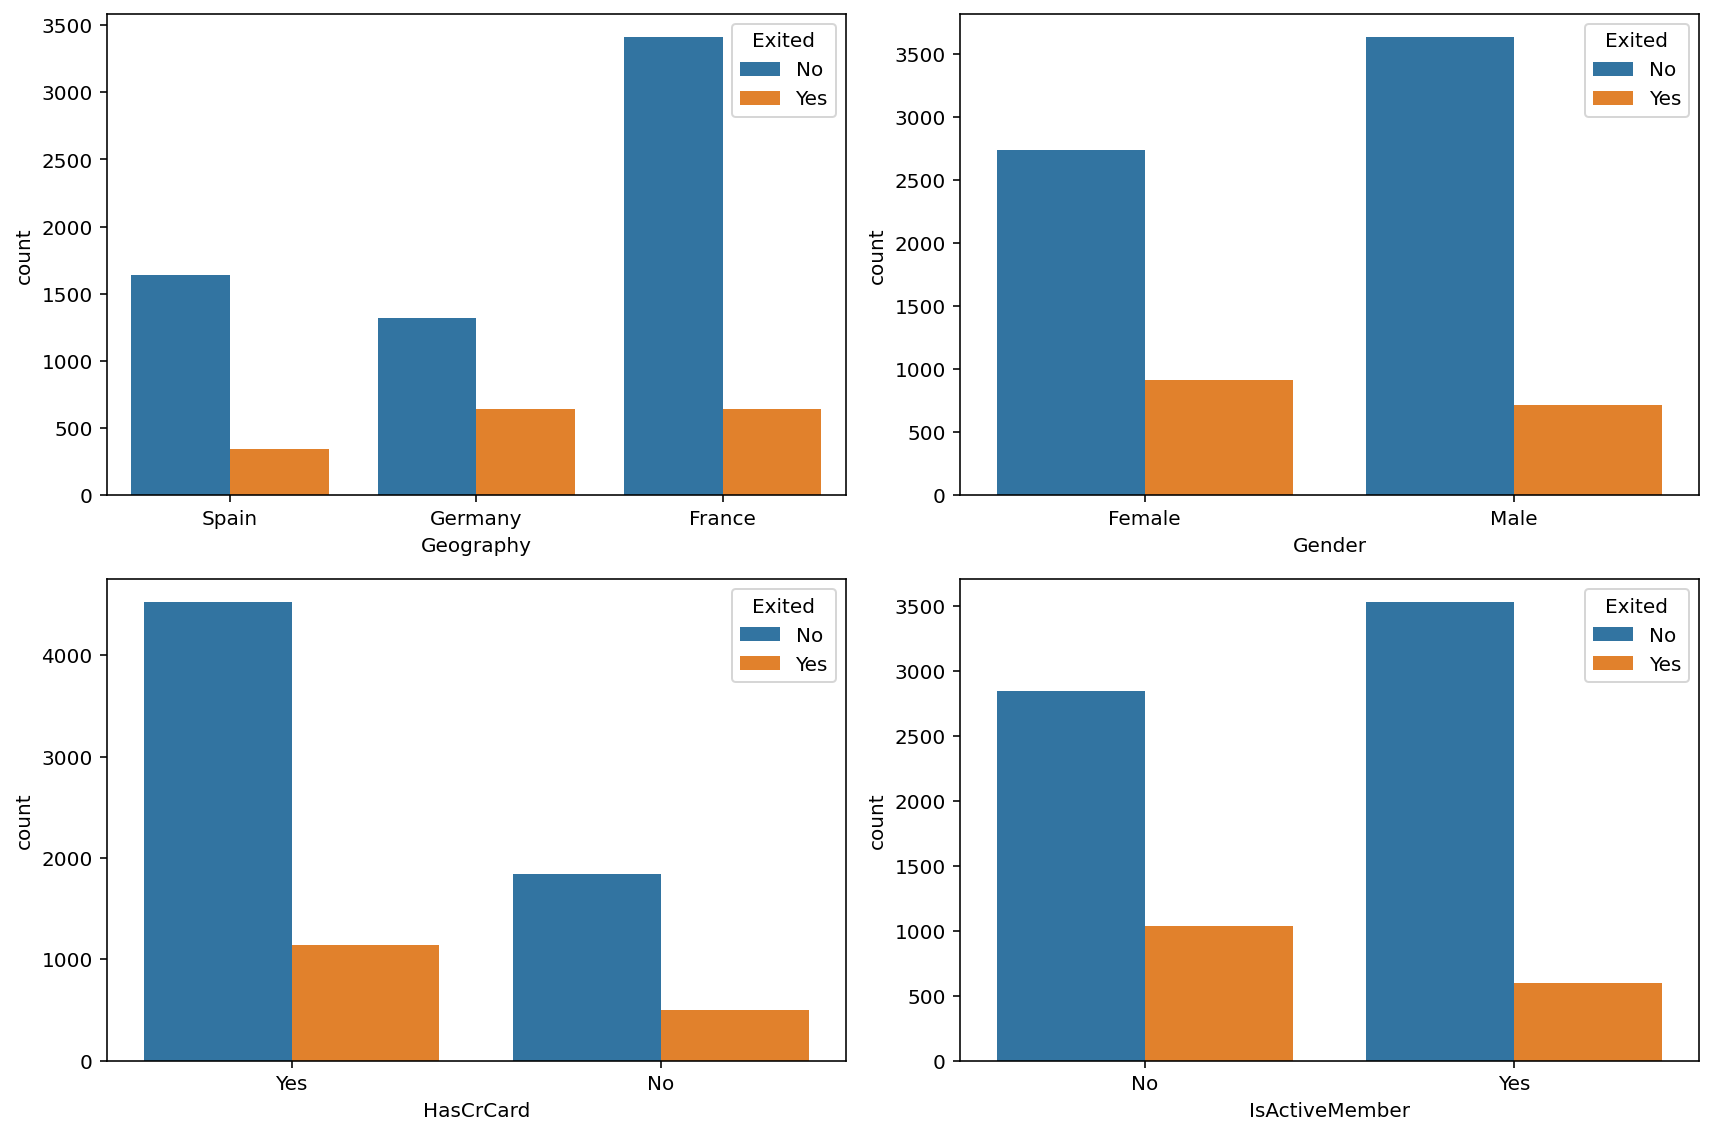

In [16]:
fig, ax = plt.subplots(len(categorical_features)//2+len(categorical_features)%2, 2, figsize=(12,8))
train = pd.concat([X_train, y_train], axis=1)
train["Exited"] = train["Exited"].apply(lambda x: "Yes" if x==1 else "No")

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue="Exited", data=train, ax=ax[i//2][i%2])
plt.tight_layout()
plt.show()

+ Histogram

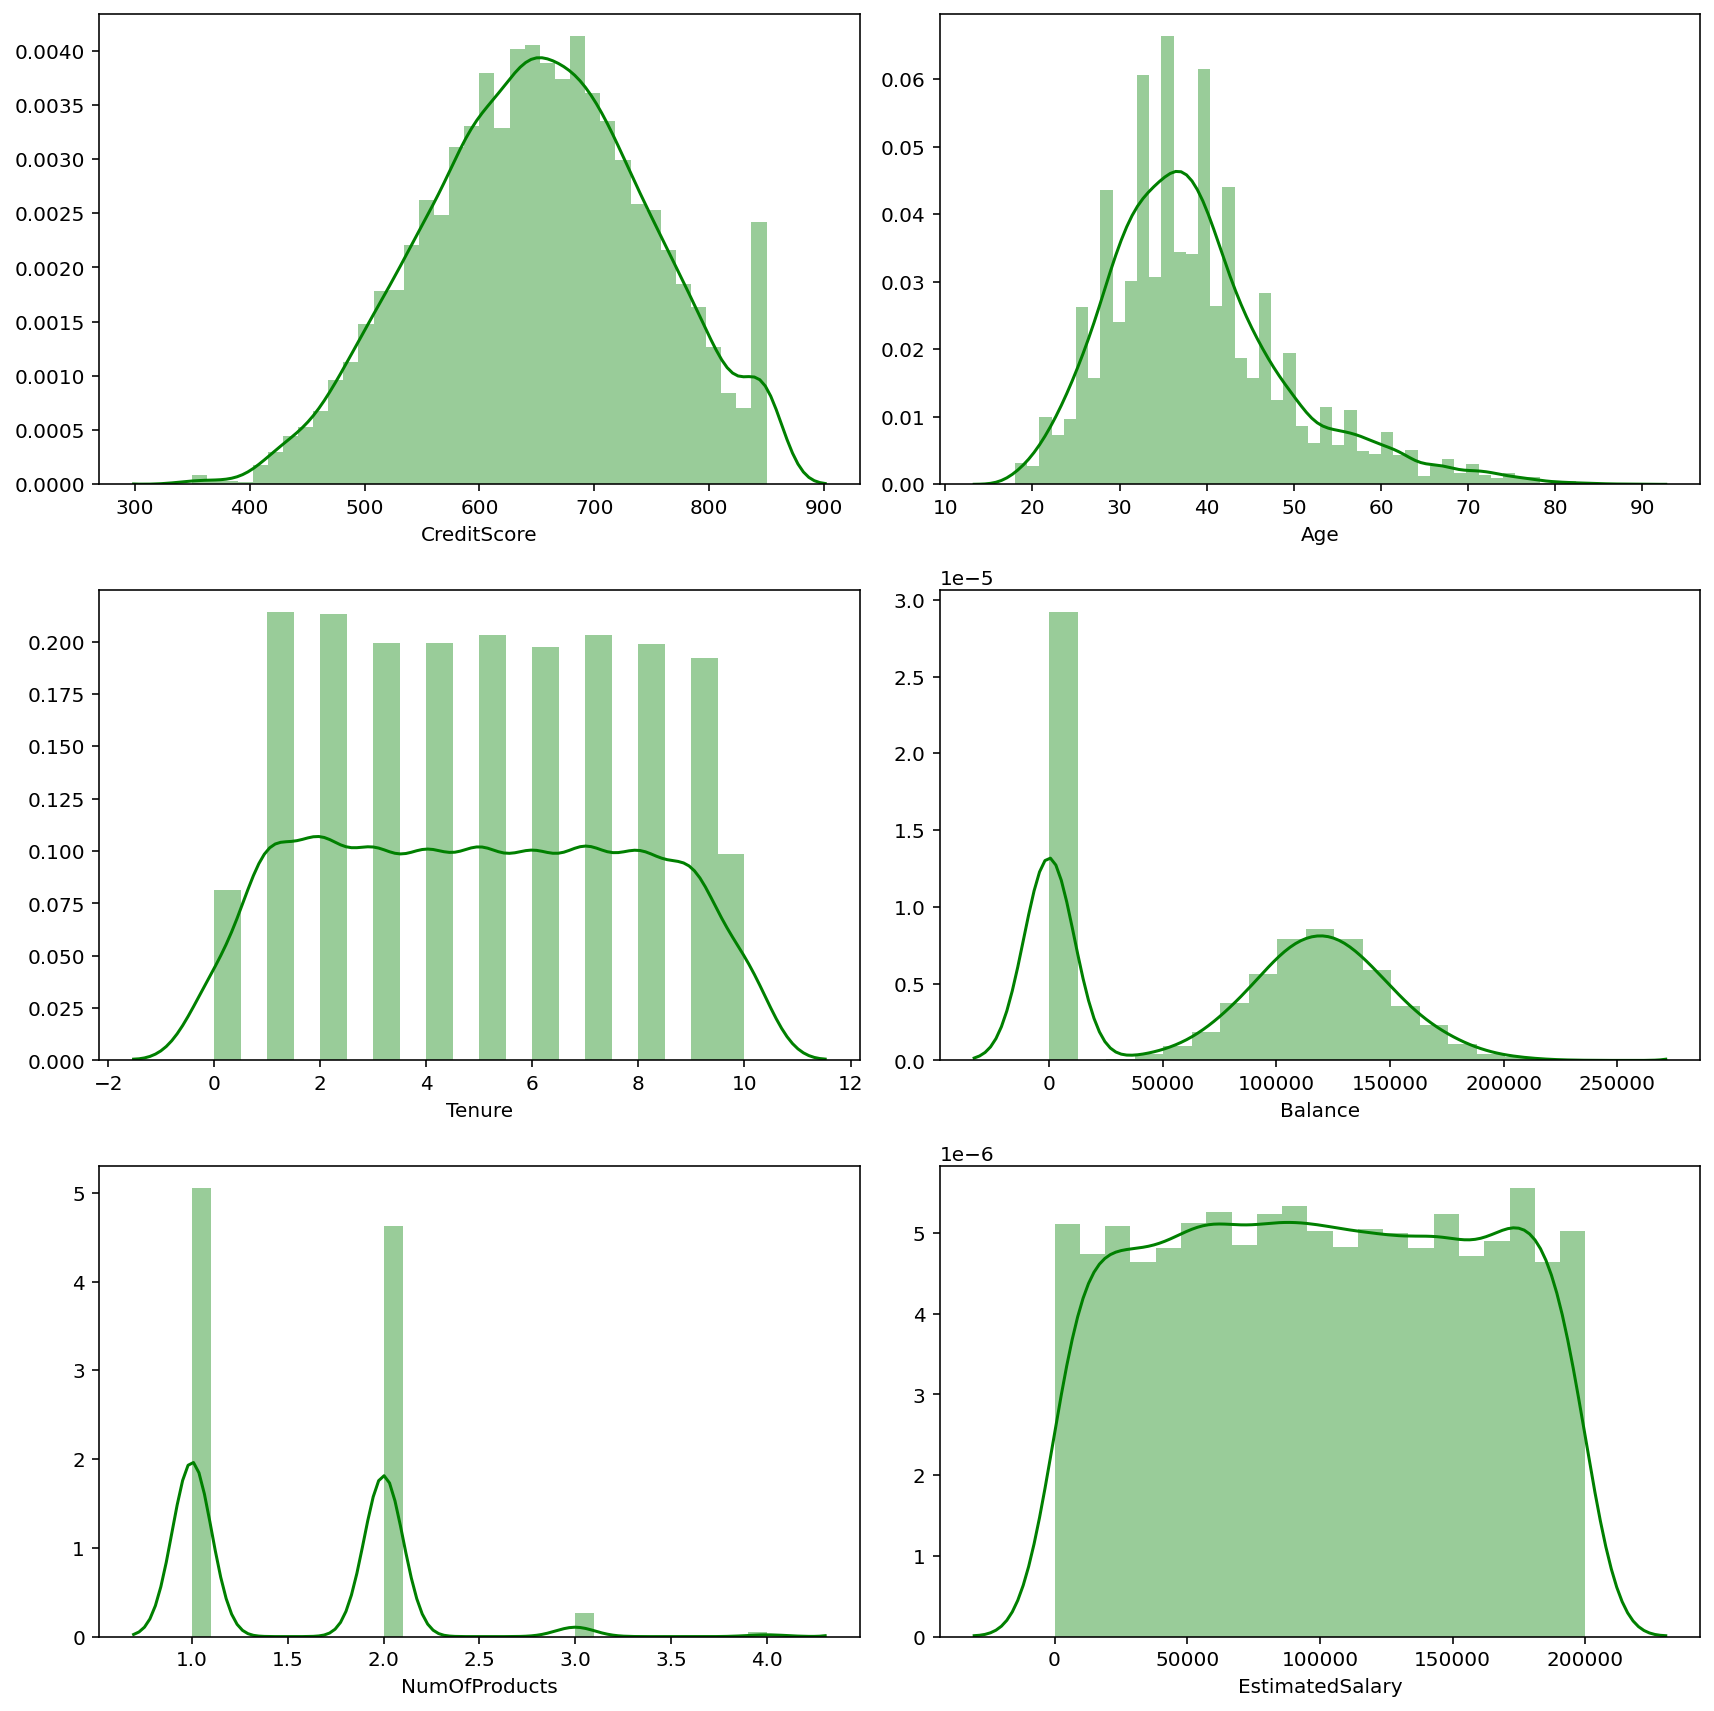

In [17]:
fig, ax = plt.subplots(len(numerical_features)//2+len(numerical_features)%2, 2, figsize=(12,12))

for i, feature in enumerate(numerical_features):
    sns.distplot(X_train[feature], color="green", ax=ax[i//2][i%2])
plt.tight_layout()
plt.show()

+ Multivariate Analysis

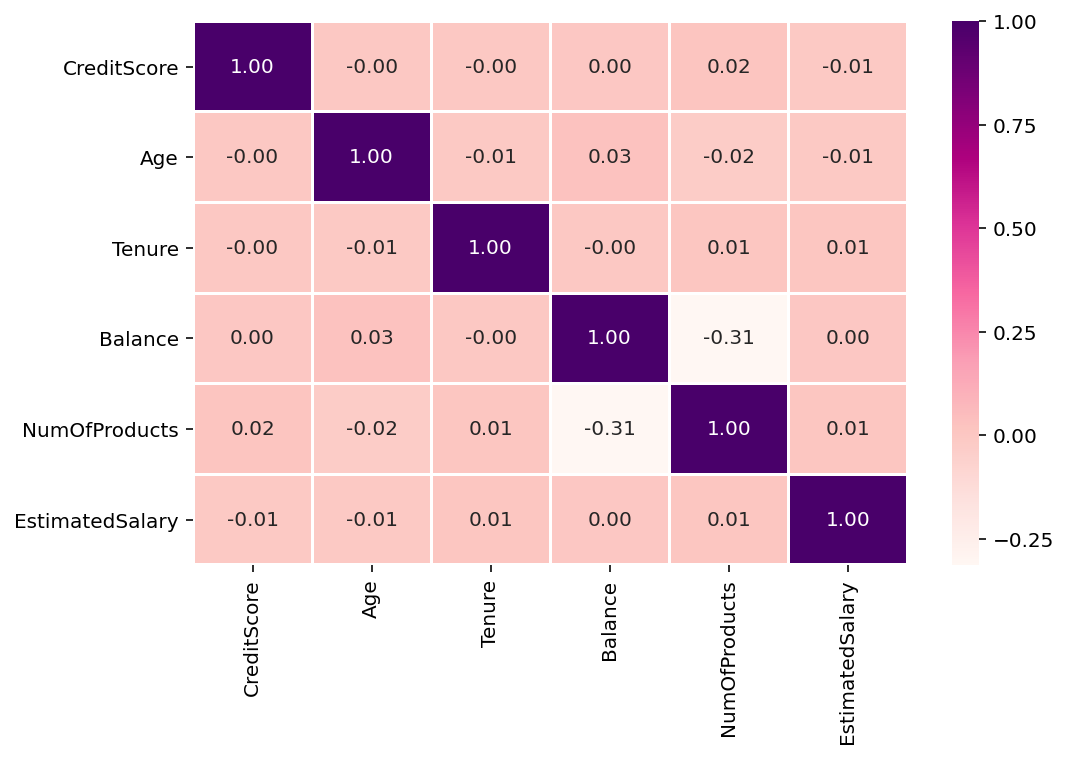

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.heatmap(X_train[numerical_features].corr(), linewidths=1, annot=True, fmt=".2f", cmap="RdPu", ax=ax)
plt.show()

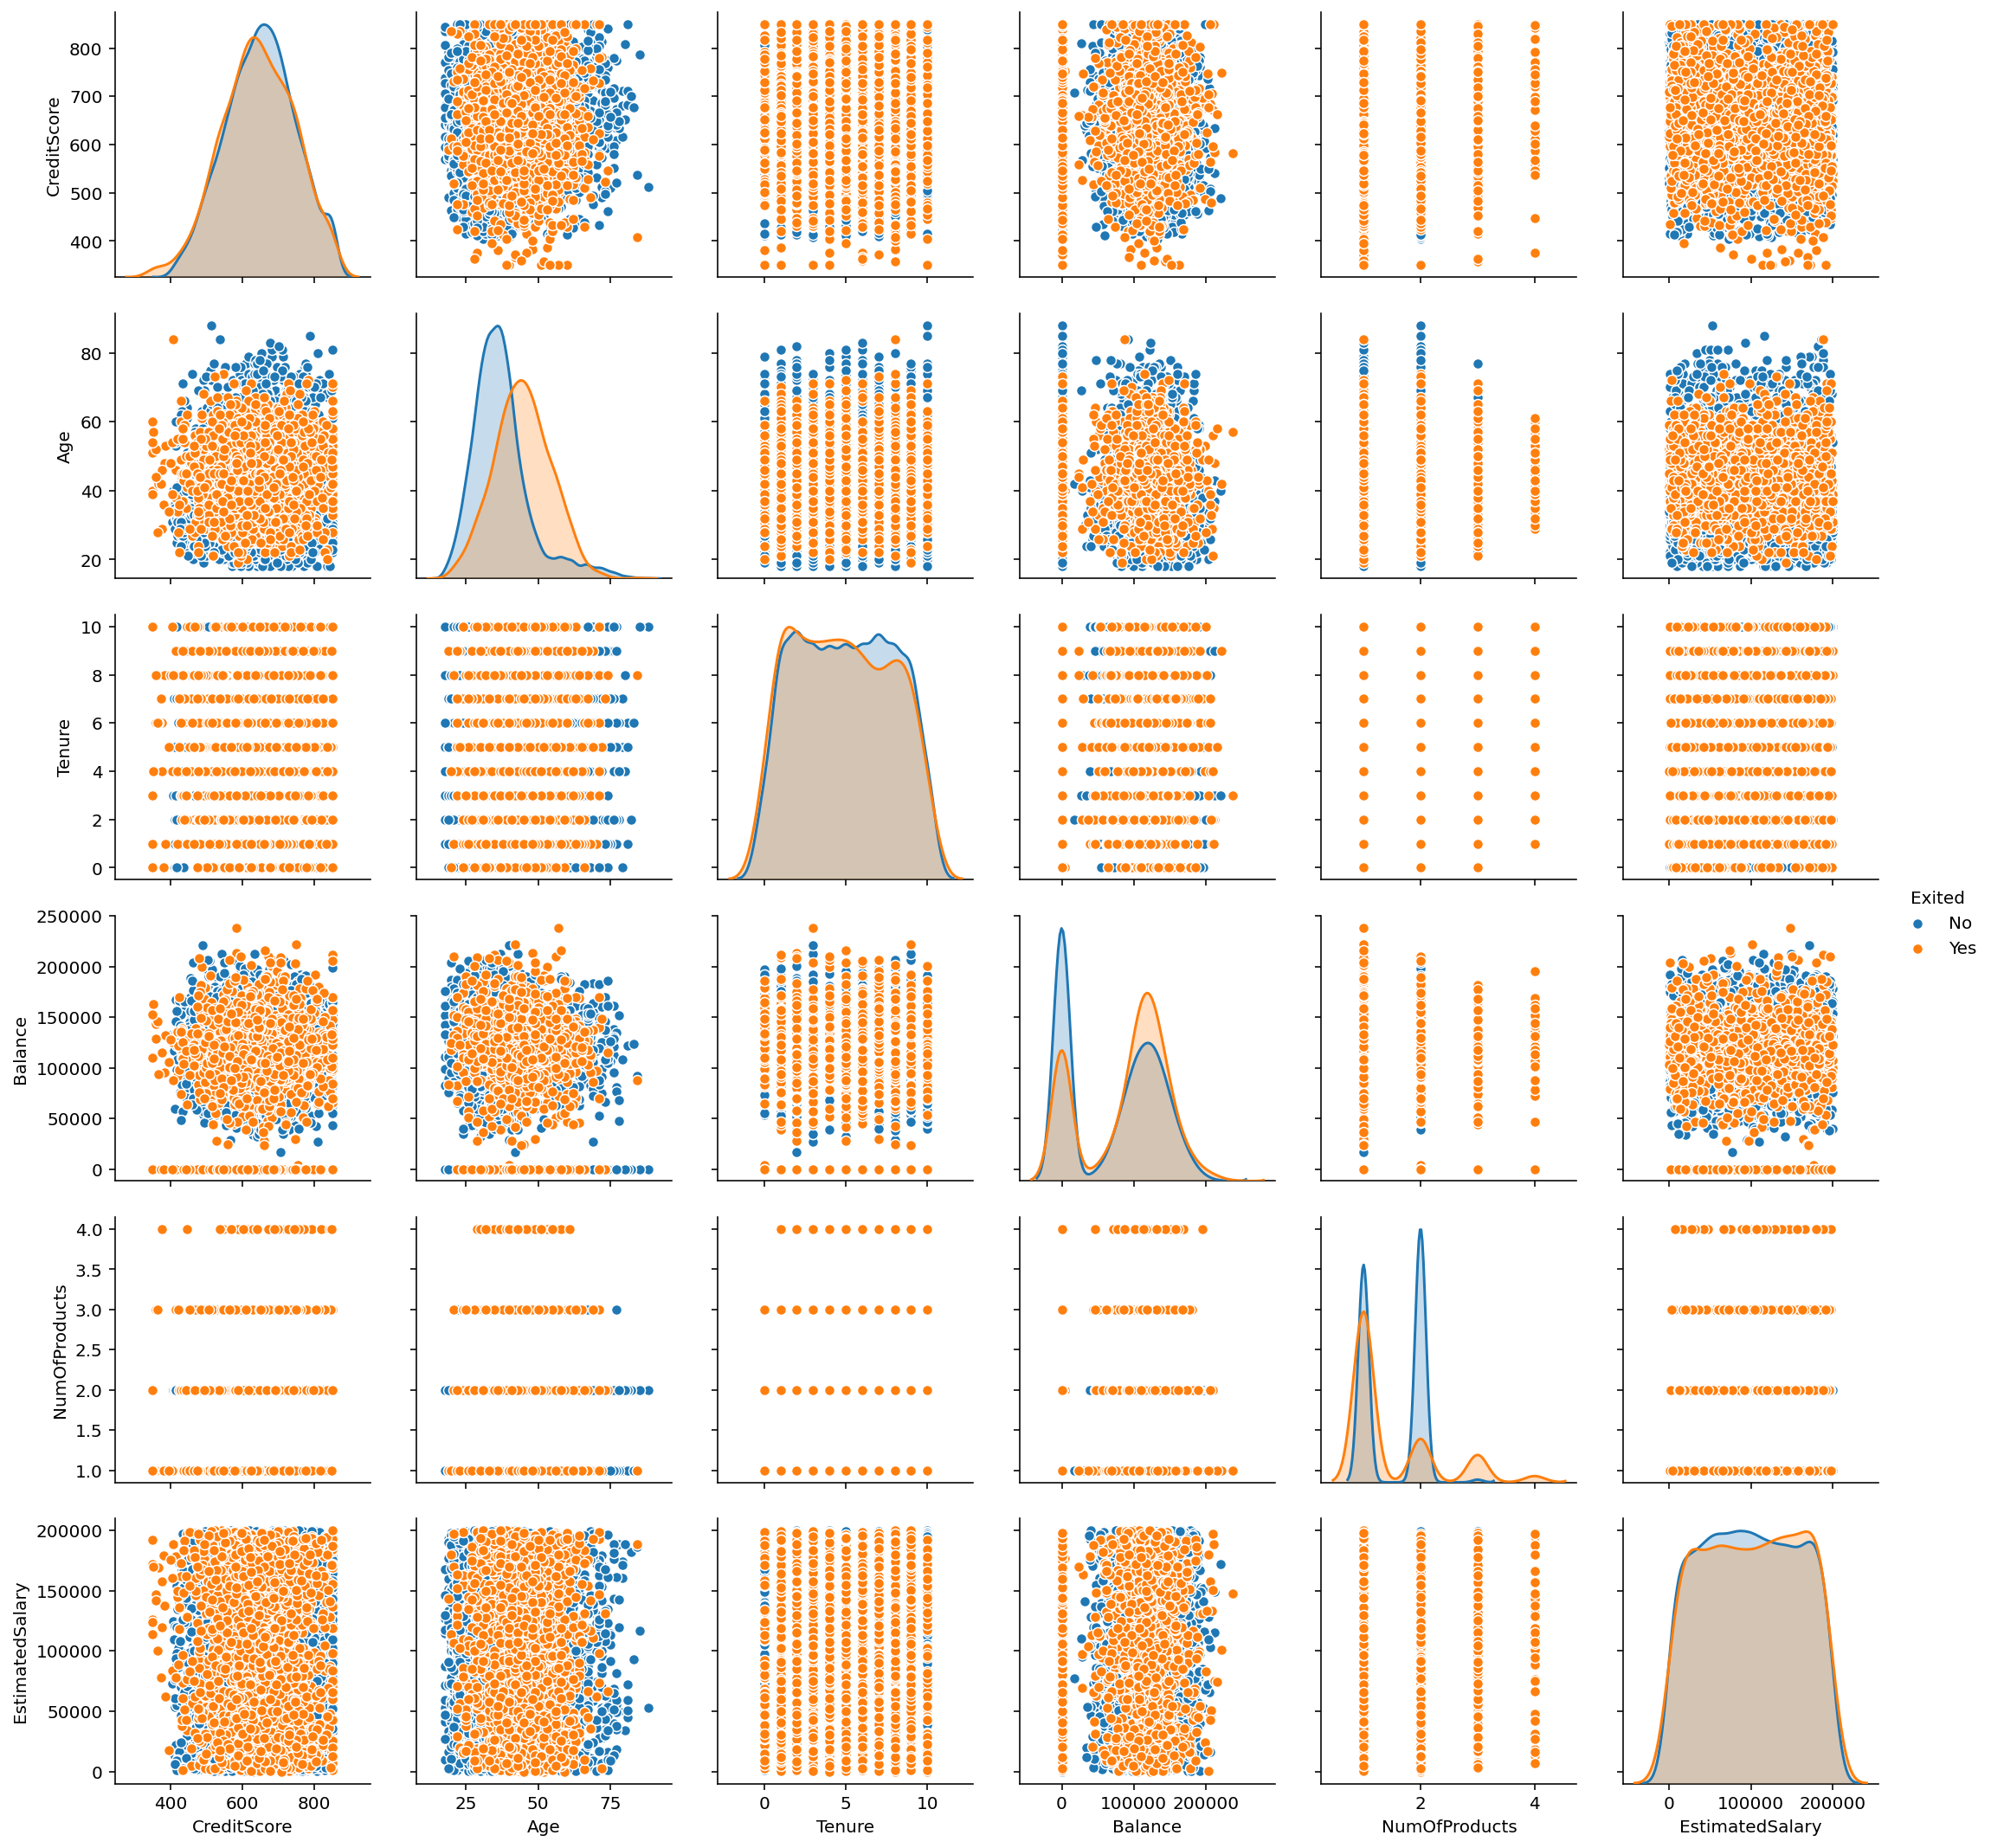

In [19]:
sns.pairplot(train, hue="Exited")

## Model

In [20]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data):
        assert isinstance(data, pd.DataFrame), "ERROR: Insert a pandas dataframe"
        return data[self.columns]

In [21]:
numerical_preprocessor = Pipeline(steps=[
    ("num_selector", ColumnSelector(numerical_features)),
    ("scaler", StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("cat_selector", ColumnSelector(categorical_features)),
    ("onehot", OneHotEncoder())
])

preprocessor = FeatureUnion(transformer_list=[
    ("numerical_preprocessor", numerical_preprocessor),
    ("categorical_preprocessor", categorical_preprocessor)])

In [22]:
def create_model():    
    model = Sequential(layers=[
        Dense(units=32, activation="relu", input_dim=preprocessor.fit_transform(X_train).shape[1]),
        BatchNormalization(),
        Dense(units=64, activation="relu"),
        Dropout(rate=0.3),
        BatchNormalization(),
        Dense(units=1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
    
    return model

neural_newtork = KerasClassifier(build_fn=create_model, epochs=30, batch_size=10, verbose=1)

In [23]:
classifier = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("nn", neural_newtork)
])

In [24]:
classifier.fit(X_train, y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
8000/8000 [==============================] - 2s 259us/step - loss: 0.4983 - acc: 0.7667
Epoch 2/30
8000/8000 [==============================] - 2s 207us/step - loss: 0.4306 - acc: 0.8108
Epoch 3/30
8000/8000 [==============================] - 2s 207us/step - loss: 0.4097 - acc: 0.8236
Epoch 4/30
8000/8000 [==============================] - 2s 208us/step - loss: 0.4009 - acc: 0.8278
Epoch 5/30
8000/8000 [==============================] - 2s 208us/step - loss: 0.3976 - acc: 0.8335
Epoch 6/30
8000/8000 [==============================] - 2s 211us/step - loss: 0.3820 - acc: 0.8370
Epoch 7/30
8000/8000 [==============================] - 2s 207us/step - loss: 0.3787 - acc: 0.8379
Epoch 8/30
8000/8000 [==============================] - 2s 206us/step - loss: 0.3769 - acc: 0.8418
Epoch 9/30
8000/8000 [==========

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('num_selector',
                                                                  ColumnSelector(columns=['CreditScore',
                                                                                          'Age',
                                                                                          'Tenure',
                                                                                          'Balance',
                                                                                          'NumOfProducts',
                                                                                          'EstimatedSalary'])),
                                                    

In [25]:
y_proba, y_pred = classifier.predict_proba(X_test), classifier.predict(X_test)

2000/2000 [==============================] - 0s 91us/step


## Model Evaluation

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.77      0.49      0.60       405

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [27]:
def confusion_matrix(y_true, y_pred):    
    matrix = pd.DataFrame(data=y_true, index=y_true.index)
    matrix.rename(columns={"Exited": "Real"}, inplace=True)
    matrix["Predicted"] = y_pred
    matrix["Predicted"] = matrix["Predicted"].apply(lambda x: "Positive" if x==1 else "Negative")
    matrix["Real"] = matrix["Real"].apply(lambda x: "Positive" if x==1 else "Negative")
    return matrix.groupby(by=["Real", "Predicted"]).size().unstack()

confusion_matrix(y_test, y_pred)

Predicted,Negative,Positive
Real,,
Negative,1535,60
Positive,205,200


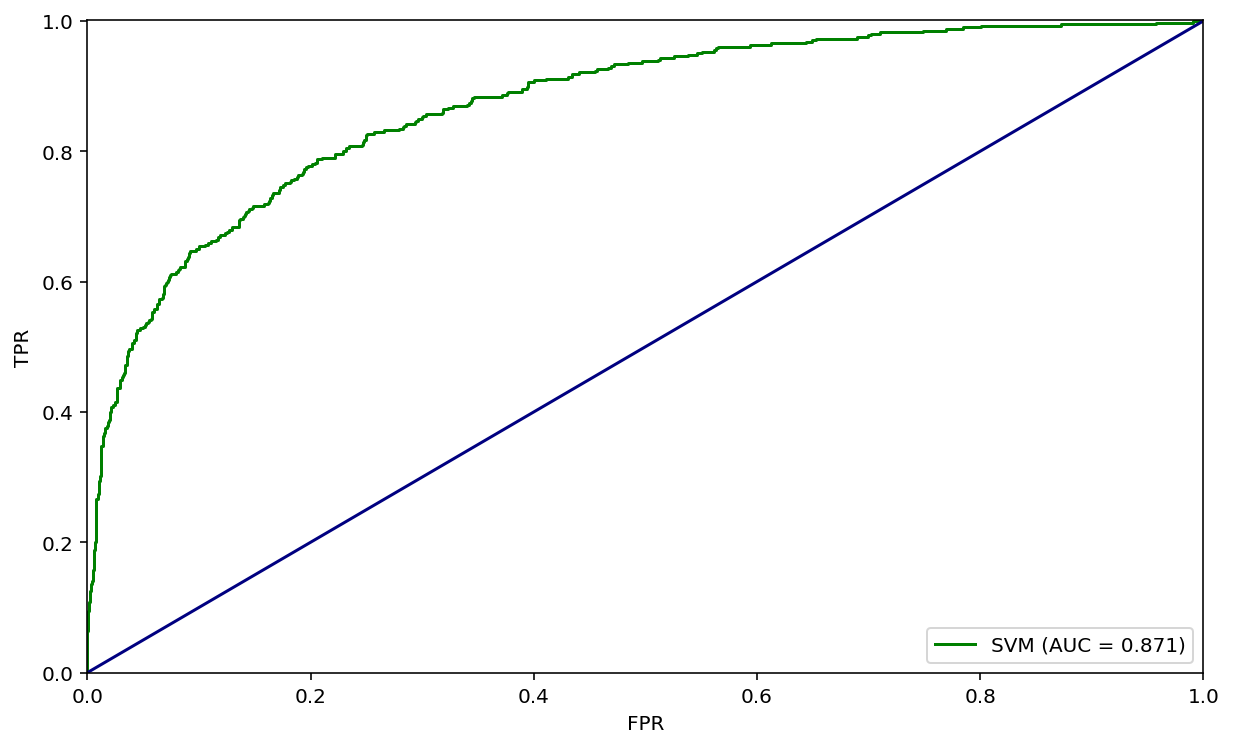

In [28]:
def plot_roc(y_true, probabilities):
    fpr, tpr, thresholds = roc_curve(y_true, probabilities[:,1])
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(fpr, tpr, color="green", label=f"SVM (AUC = {roc_auc_score(y_true, probabilities[:,1]):.3f})")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim((0,1))
    plt.ylim((0,1.001))
    plt.legend(loc=4)
    plt.show()
    
plot_roc(y_test, y_proba)

In [29]:
def plot_cap(y_true, probabilities):    
    base = pd.DataFrame(data=y_true, index=y_true.index)
    base.rename(columns={"Exited": "Real"}, inplace=True)
    base["Probability"] = probabilities[:,1]
    total = len(base[base.Real==1])
    
    perfect = (base.sort_values(by="Real", ascending=False)["Real"].cumsum()/total).values
    model = (base.sort_values(by="Probability", ascending=False)["Real"].cumsum()/total).values
    perfect = np.concatenate([[0], perfect])
    model = np.concatenate([[0], model])
    
    x = np.linspace(0, len(base), len(base)+1)/len(base)
    
    max_area = 0
    actual_area = 0
    h = x[1]-x[0]
    for i, (m, a) in enumerate(zip(perfect, model)):
        try:
            max_area+=((m-x[i])+(perfect[i-1]-(x[i-1])))*h/2
            actual_area+=((a-x[i])+(model[i-1]-(x[i-1])))*h/2
        except:
            continue
    accuracy_ratio = actual_area/max_area
    
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(x, model, color="green", label=f"SVM (AR = {accuracy_ratio:.3f})")
    plt.plot(x, perfect, color="red", label="Perfect Model")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("Reviews")
    plt.ylabel("Positive Reviews")
    plt.xlim((0,1))
    plt.ylim((0,1.01))
    plt.legend(loc=4)
    plt.show()
    
    return model, perfect, x

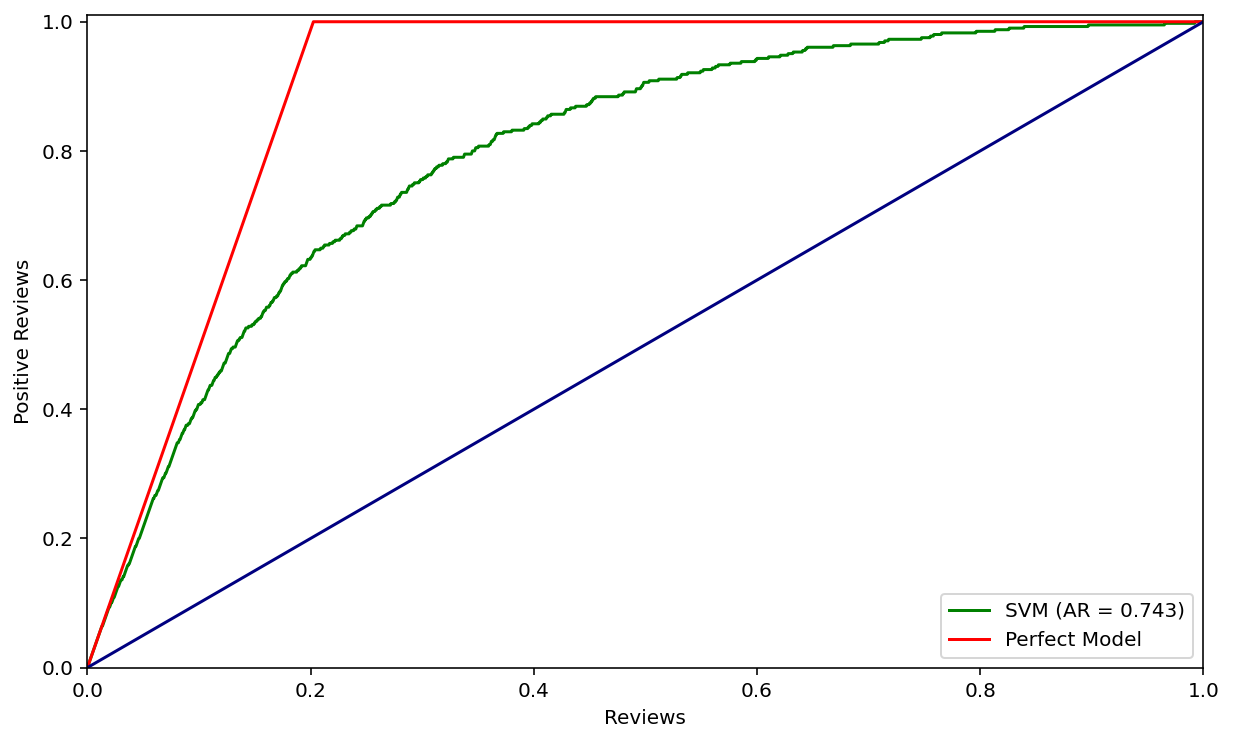

In [30]:
cap_model, cap_perfect, cap_x = plot_cap(y_test, y_proba)